# **Mount Google Drive and Import Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import numpy as np
import cv2
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import importlib


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Set Up Configuration**

In [ ]:
# Configuration from config file
MODEL_NAME = "unet"  # Name of the trained model (without .h5 extension)
MODEL_DIR = "/content/drive/MyDrive/Medical_Image_Segmentation_Pipeline/segmentation_models"  # Folder with model scripts
DATASET_PATH = "/content/drive/MyDrive/Medical_Image_Segmentation_Pipeline/dataset"  # Dataset folder containing images & masks
SAVE_MODEL_PATH = "/content/drive/MyDrive/Medical_Image_Segmentation_Pipeline/save_trained_models"  # Folder where trained models are saved
INPUT_IMAGE_PATH = "/content/drive/MyDrive/Medical_Image_Segmentation_Pipeline/input_images"  # Folder containing images for prediction
PREDICTED_MASK_PATH = "/content/drive/MyDrive/Medical_Image_Segmentation_Pipeline/predicted_masks"  # Folder where masks will be saved

# Image Processing Config
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 2
EPOCHS = 30
AUGMENTATION_FACTOR = 10  # Number of augmented samples per original image

# Ensure directories exist
os.makedirs(PREDICTED_MASK_PATH, exist_ok=True)
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)

# Define dataset paths
IMAGE_DIR = os.path.join(DATASET_PATH, "images")
MASK_DIR = os.path.join(DATASET_PATH, "masks")

# List image files
image_files = sorted(os.listdir(IMAGE_DIR))
print(f"Found {len(image_files)} images.")
print(f"Configuration Loaded: Using '{MODEL_NAME}' model for prediction")

# Add MODEL_DIR to the Python path to enable dynamic module import
sys.path.insert(0, MODEL_DIR)


Found 1 images.
Configuration Loaded: Using 'unet' model for prediction


# **Define Data Augmentation Functions and Dataset Loader**

In [ ]:
def random_flip(image, mask):
    if random.random() > 0.5:
        image = cv2.flip(image, 1)  # Horizontal flip
        mask = cv2.flip(mask, 1)
    return image, mask

def random_rotate(image, mask):
    angle = random.randint(-30, 30)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    # Use BORDER_REFLECT to avoid black borders
    image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    mask = cv2.warpAffine(mask, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    return image, mask

def adjust_brightness(image):
    factor = 0.7 + random.uniform(0, 0.6)
    return np.clip(image * factor, 0, 255).astype(np.uint8)

def load_dataset_with_augmentation(image_dir, mask_dir, augmentation_factor=5):
    images = []
    masks = []
    img_files = sorted(os.listdir(image_dir))
    for img_file in img_files:
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file)

        # Load image and mask
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Create augmented versions for each image
        for i in range(augmentation_factor):
            img_aug, mask_aug = img.copy(), mask.copy()
            img_aug, mask_aug = random_flip(img_aug, mask_aug)
            img_aug, mask_aug = random_rotate(img_aug, mask_aug)
            img_aug = adjust_brightness(img_aug)

            # Resize and normalize
            img_aug = cv2.resize(img_aug, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
            mask_aug = cv2.resize(mask_aug, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
            mask_aug = np.expand_dims(mask_aug, axis=-1)

            images.append(img_aug)
            masks.append(mask_aug)
    return np.array(images), np.array(masks)

print("Loading dataset with augmentation...")
X, y = load_dataset_with_augmentation(IMAGE_DIR, MASK_DIR, AUGMENTATION_FACTOR)
print(f"Dataset loaded: {X.shape[0]} samples.")

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Loading dataset with augmentation...
Dataset loaded: 10 samples.


# **Define Dice Loss and Dice Coefficient**

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1-(2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


# **Load and Compile the Model**

In [ ]:
import importlib

def get_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    """
    Dynamically load the model based on MODEL_NAME.
    Assumes that your model file (e.g., unet.py) exists in the models directory.
    """
    model_module = importlib.import_module(f"{MODEL_NAME}")
    return model_module.build_model(input_size)

# Load the model
model = get_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3))

# Compile the model with Adam optimizer and dice_loss
model.compile(optimizer="adam", loss=dice_loss, metrics=[dice_coefficient])

# Display the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 128, 128, 64)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 256, 256, 128)  │         65,664 │ conv2d_4[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 192)  │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 1)    │            193 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 141,505 (552.75 KB)

 Trainable params: 141,505 (552.75 KB)

 Non-trainable params: 0 (0.00 B)

# **Train the Model**

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# Save the trained model to your Google Drive
model_save_path = os.path.join(SAVE_MODEL_PATH, f"{MODEL_NAME}_trained.h5")
model.save(model_save_path)
print(f"Model saved at {model_save_path}")


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - dice_coefficient: 0.5815 - loss: 0.4185 - val_dice_coefficient: 0.6554 - val_loss: 0.3446
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - dice_coefficient: 0.6827 - loss: 0.3173 - val_dice_coefficient: 0.7381 - val_loss: 0.2619
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - dice_coefficient: 0.7539 - loss: 0.2461 - val_dice_coefficient: 0.7508 - val_loss: 0.2492
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - dice_coefficient: 0.7589 - loss: 0.2411 - val_dice_coefficient: 0.7502 - val_loss: 0.2498
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - dice_coefficient: 0.7588 - loss: 0.2412 - val_dice_coefficient: 0.7498 - val_loss: 0.2502
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - dice_coefficient: 0.7585 - loss: 0.2415 - val_dice_coefficient: 0.7499 - val_loss: 0.2501
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - dice_coefficient: 0.7590 - loss: 0.2410 - val_dice_coefficient: 0.7510 - val_loss: 0.2490
Epoch 8/30


Model saved at /content/drive/MyDrive/Medical_Image_Segmentation_Pipeline/save_trained_models/unet_trained.h5


# **Visualize Training History**

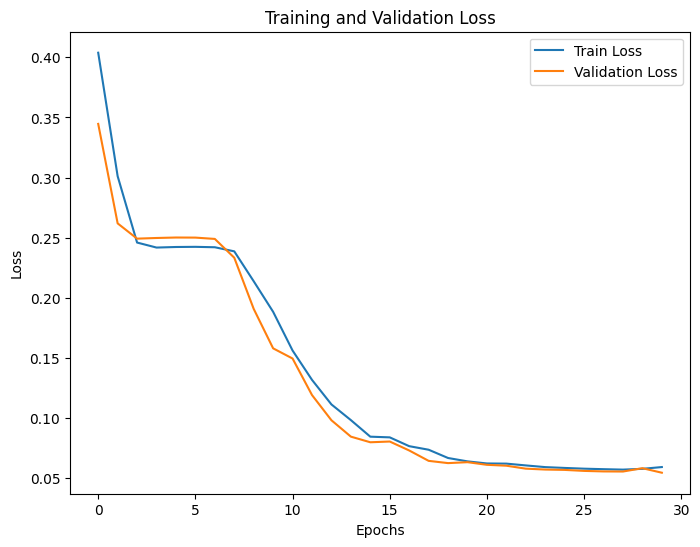

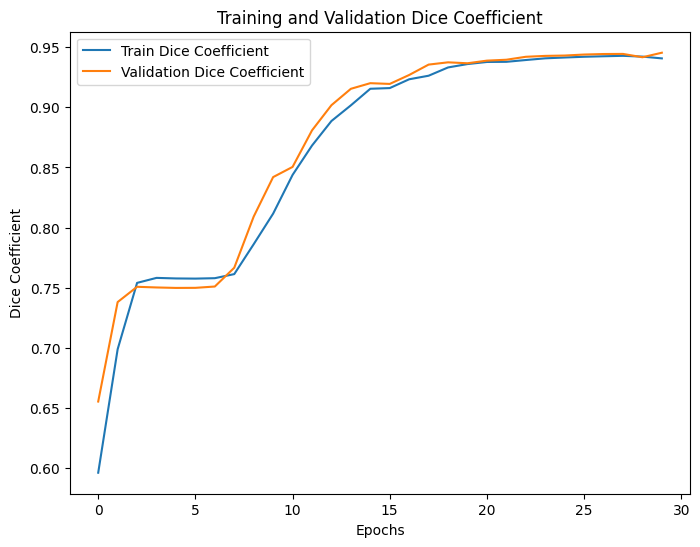

In [ ]:
# Plot Loss Curve, save and show it
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
loss_plot_path = os.path.join(SAVE_MODEL_PATH, "training_loss.png")
plt.savefig(loss_plot_path)  # Save the figure
plt.show()  # Display the plot
plt.close()  # Close the figure

# Plot Dice Coefficient Curve, save and show it
plt.figure(figsize=(8, 6))
plt.plot(history.history["dice_coefficient"], label="Train Dice Coefficient")
plt.plot(history.history["val_dice_coefficient"], label="Validation Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.title("Training and Validation Dice Coefficient")
dice_plot_path = os.path.join(SAVE_MODEL_PATH, "training_dice_coefficient.png")
plt.savefig(dice_plot_path)  # Save the figure
plt.show()  # Display the plot
plt.close()  # Close the figure
